In [1]:
from langchain_core.runnables import (
    RunnableBranch,
    RunnableLambda,
    RunnableParallel,
    RunnablePassthrough,
)
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.prompts.prompt import PromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import Tuple, List, Optional
from langchain_core.messages import AIMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
import os
from langchain_community.graphs import Neo4jGraph
from langchain.document_loaders import WikipediaLoader, WebBaseLoader
from langchain.text_splitter import TokenTextSplitter
from langchain_openai import ChatOpenAI
from langchain_groq import ChatGroq
from langchain_community.chat_models.ollama import ChatOllama
from langchain_experimental.graph_transformers import LLMGraphTransformer
from neo4j import GraphDatabase
from yfiles_jupyter_graphs import GraphWidget
from yfiles_jupyter_graphs_for_neo4j import Neo4jGraphWidget
from langchain_community.vectorstores import Neo4jVector
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores.neo4j_vector import remove_lucene_chars
from langchain_core.runnables import ConfigurableField, RunnableParallel, RunnablePassthrough
from langchain.callbacks.tracers import ConsoleCallbackHandler
from langchain.chains.graph_qa.cypher import GraphCypherQAChain

# environment variables
import os
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
!jupyter-labextension list

JupyterLab v4.1.5
/opt/miniconda3/envs/torch/share/jupyter/labextensions
        yfiles-jupyter-graphs v1.6.2 enabled OK (python, yfiles_jupyter_graphs)
        jupyterlab_pygments v0.3.0 enabled OK (python, jupyterlab_pygments)
        @jupyter-notebook/lab-extension v7.1.2 enabled OK
        @jupyter-widgets/jupyterlab-manager v5.0.10 enabled OK (python, jupyterlab_widgets)



### Setup environment

In [2]:
os.environ["NEO4J_URL"] = "bolt://localhost:7687"
os.environ["NEO4J_USERNAME"] = "neo4j"
os.environ["NEO4J_PASSWORD"] = "neo4j123456"
os.environ["NEO4J_DATABASE"] = "doc2graph"   # form10k, doc2graph

In [3]:
# connect to Neo4j
graph = Neo4jGraph(
    url=os.getenv("NEO4J_URL"), 
    username=os.getenv("NEO4J_USERNAME"), 
    password=os.getenv("NEO4J_PASSWORD"), 
    database=os.getenv("NEO4J_DATABASE"),
)
graph

### Load documents from vairous sources

In [5]:
"""
Powell             https://www.foxbusiness.com/economy/fed-chairman-powell-finds-lowering-rates-easy-swallow
News               url
Elon Musk          https://en.wikipedia.org/wiki/Elon_Musk
HSBC (Hong Kong)   https://en.wikipedia.org/wiki/HSBC_(Hong_Kong)
"""

# # Read the wikipedia article
# raw_documents = WikipediaLoader(query="Elon Musk").load()

# # from web posts
# url = "https://www.foxbusiness.com/economy/fed-chairman-powell-finds-lowering-rates-easy-swallow"
# url = "https://www.sec.gov/Archives/edgar/data/1045810/000104581023000017/nvda-20230129.htm"
# raw_documents = WebBaseLoader(url).load()

# from local PDF files
from langchain_community.document_loaders.pdf import PyPDFLoader
file_path = "/Users/leon/Downloads/10K-nvda-20240128.pdf"
raw_documents = PyPDFLoader(file_path=file_path).load()

# # from text files
# from langchain_community.docstore.document import Document
# text = """
#                                     Plastics News                                 December 10, 2007  MarketPlace  SECTION: MARKETPLACE; Pg. 16  LENGTH: 957 Words   Aussie firm's cloths may conserve water  An Australian manufacturer of plastic outdoor shade cloths wants to cover the nation's dams to save water.  But it says the viability of covering large expanses of water to cut evaporation as Australia battles against a crippling drought will depend on the future price and availability of water.  Melbourne, Australia-based Gale Pacific Ltd. has supplied high density polyethylene shade cloths for a two-year research project into water storage conducted by the Australian government's major research and development body, the Commonwealth Scientific & Industrial Research Organization.  Paul Cacioli, Gale Pacific's general manager for research and development, said CSIRO and water authorities in the state of Victoria had wanted to see whether shading dams could reduce or eliminate algal blooms that contaminated water supplies.  ``While the main reason for the research was to reduce algal blooms and other floral growths, they also recorded falls in evaporation rates of about 90 percent,'' Cacioli said.  Experiments were conducted between 2004 and 2006 at four small dams in regional Victoria using Gale Pacific shade cloth.  Cacioli said the CSIRO project had used Gale Pacific's Commercial 95 shade cloth that cut sunlight penetration by 95 percent.  The shade cloth is manufactured in rolls 9 feet 10 inches wide and 164 feet long at its plant in Ningbo, China.  Gale Pacific fashions the cloth into a range of shade products for domestic and commercial uses. The products sell in Australia and Gale Pacific has export markets in the U.S., Europe, the Middle East, and New Zealand.  Cacioli said it currently did not appear feasible to apply shade cloth to all dams, despite critical water shortages in many parts of Australia because of the ongoing drought.  ``You have to build supports for the shade cloth, and some people say it is not cost effective,'' he said.  ``But that could change, depending on the price put on water and whether it becomes less and less available.''  CSIRO said results of the research project are in the final stages of analysis. In addition to the huge reduction in evaporation rates, the shade cloths seemed to limit significant algal blooms in covered dams during summer months.  Bacterial contamination has fallen and the covers keep out water birds and wind-borne debris - all of which reduce maintenance costs.  Tel +64-3373-9500, fax +64-3373-9501.  Canada software firm aids injection molders  A new injection molding software development company has started up in Kingston, Ontario.  Injecnet Solutions Inc. aims to help companies increase quality and productivity of injection molding jobs. The firm's initial offerings are free applications for molding engineering and management at www.injecneering.com, according to company founder Mauricio Benavides.  The applications include ones on mold and machine databases, parts cost calculator, mold estimator, machine selector and mold-design revision. These programs can be stepping stones to more detailed solutions provided by Injecnet.  The firm offers a desktop version of its suite of applications so that users don't need to rely on the Web-based system.  Tel. 613-544-1109, e-mail info@ injecnet.com.  Canon to produce 3D Systems modeler  Rapid prototyping equipment supplier 3D Systems Corp. has picked Canon Virginia Inc of Newport, Va., to manufacture its V-flash compact, desktop three-dimensional modeler.  Canon, which offers contract manufacturing services, is a subsidiary of Canon U.S.A. Inc.  Canon Virginia will apply its experience making printers and copiers to the V-Flash, 3D Systems said. The V-flash, priced at $9,900, is designed to be an affordable model-making machine for businesses, hobbyists and educational institutions.  3D Systems is based in Valencia, Calif.  Tel. 800-889-2964, e-mail moreinfo@3dsystems.com  Cofit debuts latest AP screen changers  Cofit International srl of Milan, Italy, introduced its AP series screen changer, which the company said gives maximum homogeneity and a very high level of filtration.  The AP has several benefits, including a self-cleaning screen changer, with no need to take out cartridges. A simple construction and steel body make the AP durable, Cofit said.  Tel. +39-331-177-4900, fax +39-331-177-4919, e-mail cofit@ cofit.com.  Sunoco copolymers increase ductility  Sunoco Chemicals has developed a line of highly crystalline copolymers that increase ductility and low-temperature impact resistance.  The Philadelphia-based firm says its 9000 series is well-suited to the automotive industry and compounders. In addition to strength improvements, the copolymers based on ethylene and propylene improve part appearance. They can be used as a core building block to meet specific application requirements.  The four products in the 9000 series have melt flows of 15, 30, 60 and 100 grams per 10 minutes, respectively. They can boost Charpy impact strength by at least 25 percent in typical compounds, according to Sunoco.  Tel. 412-208-8194, fax 412-208-8205, e-mail ebtownsend@suno coinc.com.  New Cereplast resin withstands high heat  Cereplast Inc. has developed a higher-temperature-resistant bioplastic in its Compostables lineup.  CP-TH-6000 is a thermoforming resin able to withstand 155¬∞ F, compared with a maximum 140¬∞ F resistance typical for biodegradable and compostable resins, according to the Hawthorne, Calif., company. Based on polylactic acid, the new material relies on nanotechnology and proprietary processes to achieve its temperature rating.  CP-TH-6000 also is fully compostable, meeting the ASTM 6400 standard, according to Cereplast. Also, it is marketed at a lower price than conventional thermoformable polystyrene grades.  Tel. 310-676-5000, fax 310-676-5003, e-mail info@cereplast.com  LOAD-DATE: December 13, 2007  LANGUAGE: ENGLISH  PUBLICATION-TYPE: Newspaper  JOURNAL-CODE: pn                         Copyright 2007 Crain Communications                               All Rights Reserved                                  5 of 99 
# """
# raw_documents = [Document(page_content=text, metadata={"source": "local"})]

###############################
# Define chunking strategy
text_splitter = TokenTextSplitter(chunk_size=512, chunk_overlap=24)
# documents = text_splitter.split_documents(raw_documents[:5])
documents = text_splitter.split_documents(raw_documents)

from langchain.vectorstores.utils import filter_complex_metadata
documents = filter_complex_metadata(documents)


In [6]:
raw_documents[-3:]

[Document(page_content='        \nCOMPENSATION RECOVERY POLICY\nIf any provision of this Policy or the application of any provision to a Covered Of ficer shall be adjudicated to be invalid, illegal or unenforceable in any respect,\nsuch invalidity , illegality or unenforceability shall not af fect any other provisions of this Policy , and the invalid, illegal or unenforceable provisions shall be deemed\namended to the minimum extent necessary to render any such provision or application enforceable.\nThe Committee may amend, terminate or replace this Policy or any portion of this Policy at any time in its sole discretion, and shall amend this Policy as it\ndeems necessary to comply with applicable law or listing standards.\nSpeak Up | Reporting Concerns\nIf you are aware of a situation that may violate this Policy , you have a responsibility to report the incident to your immediate supervisor , Corporate Legal or to\nNVIDIA-Compliance. Reports may also be submitted anonymously by using 

In [184]:
# documents = documents[:len(documents)-1]
# len(raw_documents), 
len(documents), documents[-3:]

(204,
 [Document(page_content='        \nCOMPENSATION RECOVERY POLICY\nDefinitions\nAccounting\nRestatementAn accounting restatement that the Company is required to prepare due to the material noncomp liance of the Company with\nany financia l reporting requirement under the securities laws, including any required accounting  restatement to correct an\nerror in previously issued financial statements that is material to the previously issued financial statements, or that would\nresult in a material misstatement if the error were corrected in the current period or left uncorrected in the current period\nAccounting\nRestatement DateThe earlier to occur of (i) the date that the Board, a committee of the Board, or the officer or officers of the Company\nauthorized to take such action if Board action is not required, concludes, or reasonably should have concluded, that the\nCompany is required to prepare an Accountin g Restatement, or (ii) the date that a court, regulator or other legally\na

In [8]:
# setup llm
llm=ChatGroq(
    temperature=0, 
    model_name="llama3-70b-8192",
    # verbose=True,
) 

# llm=ChatOpenAI(
#     temperature=0, 
#     # model_name="gpt-3.5-turbo-0125",
# ) # gpt-4-0125-preview occasionally has issues

# from langchain_community.chat_models import ChatOllama
# llm = ChatOllama(
#     model="mistral:7b-instruct-v0.2-fp16",
#     temperature=0,
# )


In [9]:
response = llm.invoke("Tell me a quick joke")
response.content

"Why couldn't the bicycle stand up by itself?\n\nBecause it was two-tired!"

### Parse graph_documents from documents

In [12]:
prompt = ChatPromptTemplate.from_messages([
            ("assistant", 
             """
            You are a experienced financial analyst who excel at analyzing 10K annual financial reports, 
            which is a 10k form filing from a public company to SEC.
            Your goal is to parse the following documents into a graph structure.
            You will only extract entities and corresponding relationships that are comprehensive.
            """),
        ])

llm_transformer = LLMGraphTransformer(
    llm=llm, 
    # allowed_nodes=['Company', 'Organization', 'Person', 'University', 'Location', 'Government', 'Product', 'Market', 'FinancialReporting'],
    allowed_nodes=[],
    allowed_relationships=[],
    # prompt=prompt,
)

In [14]:
len(documents), documents[168:169]

(204,
 [Document(page_content='Table of Contents\nNVIDIA  Corporation and Subsidiaries\nNotes to the Consolidated Financial Statements\n(Continued)\nNote 14 - Income Taxes\nThe income tax expense (benefit) applicable to income before income taxes consists of the following:\n Year Ended\n Jan 28, 2024 Jan 29, 2023 Jan 30, 2022\n (In millions)\nCurrent income taxes:    \nFederal $ 5,710 $ 1,703 $ 482 \nState 335 46 42 \nForeign 502 228 71 \nTotal current 6,547 1,977 595 \nDeferred income taxes:    \nFederal (2,499) (2,165) (420)\nState (206) — — \nForeign 216 1 14 \nTotal deferred (2,489) (2,164) (406)\nIncome tax expense (benefit) $ 4,058 $ (187) $ 189 \nIncome before income tax consists of the following:\n Year Ended\n Jan 28, 2024 Jan 29, 2023 Jan 30, 2022\n (In millions)\nU.S. $ 29,495 $ 3,477 $ 8,446 \nForeign 4,323 704 1,495 \nIncome before income tax $ 33,818 $ 4,181 $ 9,941 \nThe income tax expense (benefit) dif fers from the amount computed by applying the U.S. federal statutory

In [15]:
# convert data
from tqdm import tqdm

graph_documents = llm_transformer.convert_to_graph_documents(tqdm(documents))
# graph_documents = llm_transformer.convert_to_graph_documents(tqdm(documents[:169]))
# graph_documents = llm_transformer.convert_to_graph_documents([documents[113]])

  0%|          | 0/204 [00:00<?, ?it/s]

100%|██████████| 204/204 [1:28:20<00:00, 25.98s/it]


In [16]:
len(graph_documents), graph_documents[-1]

(204,
 GraphDocument(nodes=[Node(id='Nvidia Corporation', type='Company'), Node(id='Compensation Recovery Policy', type='Policy'), Node(id='Executive Acknowledgment', type='Form'), Node(id='November 30, 2023', type='Date'), Node(id='Committee', type='Entity'), Node(id='Company', type='Entity')], relationships=[Relationship(source=Node(id='Nvidia Corporation', type='Company'), target=Node(id='Compensation Recovery Policy', type='Policy'), type='HAS_POLICY'), Relationship(source=Node(id='Executive Acknowledgment', type='Form'), target=Node(id='Compensation Recovery Policy', type='Policy'), type='RELATED_TO'), Relationship(source=Node(id='Committee', type='Entity'), target=Node(id='Compensation Recovery Policy', type='Policy'), type='ADMINISTRATOR_OF')], source=Document(page_content='Exhibit A\nNVIDIA Corporation\nCompensation Recovery Policy\nForm of Executive Acknowledgment\nI, the unders igned, agree and acknowledge that I am bound by, and subject to, the NVIDIA  Corporation Compensati

In [17]:
# type(graph_documents), 
graph_documents[-1].to_json()

{'lc': 1,
 'type': 'not_implemented',
 'id': ['langchain_community', 'graphs', 'graph_document', 'GraphDocument'],
 'repr': "GraphDocument(nodes=[Node(id='Nvidia Corporation', type='Company'), Node(id='Compensation Recovery Policy', type='Policy'), Node(id='Executive Acknowledgment', type='Form'), Node(id='November 30, 2023', type='Date'), Node(id='Committee', type='Entity'), Node(id='Company', type='Entity')], relationships=[Relationship(source=Node(id='Nvidia Corporation', type='Company'), target=Node(id='Compensation Recovery Policy', type='Policy'), type='HAS_POLICY'), Relationship(source=Node(id='Executive Acknowledgment', type='Form'), target=Node(id='Compensation Recovery Policy', type='Policy'), type='RELATED_TO'), Relationship(source=Node(id='Committee', type='Entity'), target=Node(id='Compensation Recovery Policy', type='Policy'), type='ADMINISTRATOR_OF')], source=Document(page_content='Exhibit A\\nNVIDIA Corporation\\nCompensation Recovery Policy\\nForm of Executive Acknowle

### SAVE graph documents (sooooooooo time consuming..)

In [18]:
# save graph_documents
import json

k = 0
for graph_document in tqdm(graph_documents):
    with open(f"__nvda_10k_data/nvda_10k_2023_fin_{k}.json", "w") as f:
        json.dump(graph_document.to_json(), f, indent=4)
    k += 1
    

100%|██████████| 204/204 [00:00<00:00, 3428.17it/s]


In [37]:
from langchain_community.graphs.graph_document import GraphDocument
# from langchain_community.document_loaders import JSONLoader
# from pathlib import Path
# from pprint import pprint

with open("__nvda_10k_data/nvda_10k_2023_fin_158.json", "r") as f:
    graph_json = json.load(f)

print(graph_json['repr'])
# graph_document = GraphDocument.parse_file("__nvda_10k_data/nvda_10k_2023_fin_158.json")
# # graph_document = graph_json['repr']

# graph_document

# file_path='__nvda_10k_data/nvda_10k_2023_fin_158.json'
# loader = JSONLoader(
#     file_path=file_path,
#     jq_schema='.repr[]',
#     text_content=False)
# data = loader.load()
# pprint(data)

GraphDocument(nodes=[Node(id='Federal Research And Development Tax Credit', type='Tax credit'), Node(id='Foreign Tax Rate Differential', type='Tax rate differential'), Node(id='Ip Domestication', type='Ip domestication'), Node(id='Other', type='Other'), Node(id='Income Tax Expense (Benefit)', type='Income tax expense (benefit)')], relationships=[Relationship(source=Node(id='Federal Research And Development Tax Credit', type='Tax credit'), target=Node(id='278', type='Percentage'), type='HAS_PERCENTAGE'), Relationship(source=Node(id='Federal Research And Development Tax Credit', type='Tax credit'), target=Node(id='6.6', type='Percentage'), type='HAS_PERCENTAGE'), Relationship(source=Node(id='Foreign Tax Rate Differential', type='Tax rate differential'), target=Node(id='83', type='Percentage'), type='HAS_PERCENTAGE'), Relationship(source=Node(id='Foreign Tax Rate Differential', type='Tax rate differential'), target=Node(id='2.0', type='Percentage'), type='HAS_PERCENTAGE'), Relationship(so

### Generate graphs
- clean database
- drop vector index

In [32]:
# test purpose, delete existing data to reset
if graph.query("match p=()-->() return count(p) as isExist")[0]['isExist'] > 0:
    graph.query(
        """
        MATCH p=()-->()
        DETACH DELETE p
        """
    )
    print(graph.query("match p=()-->() return count(p) as isExist")[0]['isExist'])

# graph.query("DROP INDEX vector")

0


In [33]:
graph_documents[158]

GraphDocument(nodes=[Node(id='Nvidia Corporation', type='Company'), Node(id='Property And Equipment', type='Asset'), Node(id='Land', type='Asset'), Node(id='Buildings, Leasehold Improvements, And Furniture', type='Asset'), Node(id='Equipment, Compute Hardware, And Software', type='Asset'), Node(id='Construction In Process', type='Asset'), Node(id='Prepaid Supply And Capacity Agreements', type='Asset'), Node(id='Investments In Non-Affiliated Entities', type='Asset'), Node(id='Prepaid Royalties', type='Asset'), Node(id='Other', type='Asset')], relationships=[Relationship(source=Node(id='Nvidia Corporation', type='Company'), target=Node(id='Property And Equipment', type='Asset'), type='OWNS'), Relationship(source=Node(id='Property And Equipment', type='Asset'), target=Node(id='Land', type='Asset'), type='INCLUDES'), Relationship(source=Node(id='Property And Equipment', type='Asset'), target=Node(id='Buildings, Leasehold Improvements, And Furniture', type='Asset'), type='INCLUDES'), Relati

In [34]:
# ingest data into graph
graph.add_graph_documents(
    tqdm(graph_documents),
    baseEntityLabel=True,
    include_source=True
)

100%|██████████| 204/204 [00:03<00:00, 58.08it/s]


In [35]:
# # ingest data into graph
# graph.add_graph_documents(
#     tqdm(graph_documents[159:]),
#     baseEntityLabel=True,
#     include_source=True
# )

In [5]:
graph.refresh_schema()
graph.schema

'Node properties:\nDocument {id: STRING, source: STRING, page: INTEGER, text: STRING, embedding: LIST}\nPerson {id: STRING}\nCompany {id: STRING}\nFoundation {id: STRING}\nUniversity {id: STRING}\nGovernment agency {id: STRING}\nLocation {id: STRING}\nCountry {id: STRING}\nOrganization {id: STRING}\nCity {id: STRING}\nRegion {id: STRING}\nContinent {id: STRING}\nCurrency {id: STRING}\nYear {id: STRING}\nAuthority {id: STRING}\nTopic {id: STRING}\nEvent {id: STRING}\nCondition {id: STRING}\nWebsite {id: STRING}\nCategory {id: STRING}\nConcept {id: STRING}\nAcronym {id: STRING}\nIndex {id: STRING}\nEconomic indicator {id: STRING}\nStock {id: STRING}\nTool {id: STRING}\nGroup {id: STRING}\nEconomic concept {id: STRING}\nFinancial concept {id: STRING}\nState {id: STRING}\nDevice {id: STRING}\nAi model {id: STRING}\nPlatform {id: STRING}\nEntity {id: STRING}\nFiler {id: STRING}\nAct {id: STRING}\nSection {id: STRING}\nRule {id: STRING}\nMarket {id: STRING}\nItem {id: STRING}\nSocial media {

### Check graph

In [6]:
cypher_elon = """
MATCH (p)-[r]->(c) 
where p.id contains "Elon"
//RETURN c order by c.id
RETURN p,r, c
"""

cypher_hsbc = """ 
match (b:Bank)-[r]->(n)
return b, r, n
"""

# cypher = """MATCH p=()-[:!MENTIONS]->() RETURN p"""
cypher = """
match p=()-[:!MENTIONS]->(n:Report {id: "Annual Report On Form 10-K"})-[]->()
return p limit 50
"""

In [7]:
# directly show the graph resulting from the given Cypher query
def showGraph(cypher: str):
    # create a neo4j session to run queries
    driver = GraphDatabase.driver(
        uri = os.getenv("NEO4J_URL"),
        auth = (os.getenv("NEO4J_USERNAME"),
                os.getenv("NEO4J_PASSWORD")),
        database = os.getenv("NEO4J_DATABASE"),

    )
    
    # from GraphWidget
    session = driver.session()
    
    graph2 = session.run(cypher).graph()
    
    session.run(cypher)
    
    widget = GraphWidget(graph=graph2)
    widget.hierarchic_layout()
    widget.set_node_label_mapping('id')
    # widget.node_label_mapping = 'id'
    # widget.graph_layout = 'hierarchic'
    driver.close()
    
    
    # # from GraphWidget
    # widget = GraphWidget(graph=graph2)

    # # from Neo4jGraphWidget
    # widget = Neo4jGraphWidget(driver=driver,)
    # widget.show_cypher(cypher)
    # widget

    # display(widget)
    widget.show()
    return 

In [8]:
showGraph("""MATCH p=()-[r:IMPACT]->() RETURN p LIMIT 25""")

GraphWidget(layout=Layout(height='800px', width='100%'))

In [40]:
import json
# print(json.dumps(graph.query(cypher), indent=4))
graph.query(cypher)

[{'p': [{'id': 'Exhibits 32.1 And 32.2'},
   'PART_OF',
   {'id': 'Annual Report On Form 10-K'},
   'GOVERNED_BY',
   {'id': 'Section 18 Of The Exchange Act'}]},
 {'p': [{'id': 'Note 13'},
   'PART_OF',
   {'id': 'Annual Report On Form 10-K'},
   'GOVERNED_BY',
   {'id': 'Section 18 Of The Exchange Act'}]},
 {'p': [{'id': 'Part Iv, Item 15'},
   'PART_OF',
   {'id': 'Annual Report On Form 10-K'},
   'GOVERNED_BY',
   {'id': 'Section 18 Of The Exchange Act'}]},
 {'p': [{'id': 'Note 12'},
   'PART_OF',
   {'id': 'Annual Report On Form 10-K'},
   'GOVERNED_BY',
   {'id': 'Section 18 Of The Exchange Act'}]},
 {'p': [{'id': 'Note 3'},
   'PART_OF',
   {'id': 'Annual Report On Form 10-K'},
   'GOVERNED_BY',
   {'id': 'Section 18 Of The Exchange Act'}]},
 {'p': [{'id': 'Nvidia Corporation'},
   'CONTAINS',
   {'id': 'Annual Report On Form 10-K'},
   'GOVERNED_BY',
   {'id': 'Section 18 Of The Exchange Act'}]},
 {'p': [{'id': 'Proxy Statement'},
   'INCORPORATED_BY_REFERENCE',
   {'id': 'Annua

#### Adjust graph for tailoring improvement

In [41]:
graph.query("""MATCH (n:Company) where n.id = "Nvidia Corporation" or n.id = "Nvidia" RETURN n """)

[{'n': {'id': 'Nvidia'}}, {'n': {'id': 'Nvidia Corporation'}}]

In [42]:
# merge Nodes: Elon Musk, Elon, Elon Reeve Musk
merge_elon = """
MATCH (p:Person) where p.id 
contains "Elon" 
with collect(p) as nodes
call apoc.refactor.mergeNodes(nodes, {properties:{
    id: 'discard',
    mergeRels: True
}})
yield node
return node
"""

merge_nvda = """
MATCH (n:Company) 
where n.id = "Nvidia Corporation" or n.id = "Nvidia" 
with collect(n) as nodes
call apoc.refactor.mergeNodes(nodes, {properties:{
    id: 'overwrite',
    mergeRels: True
}})
yield node
return node
"""

# # delete relationship
# del_rel = """ 
# match (p:Person)-[r:VISITED]->()
# where p.id contains "Biden" and elementId(r)="5:73b77fec-7529-4f4b-8f8d-f7b79f053d72:104"
# delete r
# """

graph.query(merge_nvda)

[{'node': {'id': 'Nvidia Corporation'}}]

In [12]:
showGraph("""
MATCH p=(n:Company)-[*]->(r:__Entity__) 
WHERE n.id="Nvidia Corporation" AND r.id="Registrant"
RETURN p LIMIT 10
""")

GraphWidget(layout=Layout(height='770px', width='100%'))

### QA Cypher Chain

In [111]:
CYPHER_GENERATION_TEMPLATE = """
Task: 
    Generate Cypher statement to query a graph database.
Instructions:
    Use only the provided relationship types and properties in the schema.
    Do not use any other relationship types or properties that are not provided.
    If you cannot generate a Cypher statement based on the provided schema, explain the reason to the user.
    When you use `MATCH` with `WHERE` clauses, always first check the entities' or relationships; id property rather than name.
    
Schema:
{schema}
IMPORTANT: 
    Do not include any explanations or apologies in your response.
    Do not respond to any questions that might ask anything else than for you to construct a Cypher statement.
    Do not include any text except the generated Cypher statement.
Examples:
Here are a few examples of generated Cypher statements for particular questions:

# Example 1: What entities relates to Nvidia Corporation?
MATCH p=()-[]->(n:Company)-[]->()
where n.id = "Nvidia Corporation"
RETURN p LIMIT 50

# Example 2: What assets do Nvidia Corporation have?
MATCH p=(n:Company)-[r:HAS]->() 
where n.id = "Nvidia Corporation"
RETURN p LIMIT 25

# Example 3: Where is Nvidia Corporate Headquatered in?
MATCH p=(n:Company)-[:HEADQUARTERED_IN]->()
WHERE n.id = 'Nvidia Corporation'
RETURN p

# Example 4: What insights can we get from `IMPACTS` as relationship?
MATCH p=()-[r:IMPACTS]->() 
RETURN p LIMIT 25

# Example 5: What insights can we get from `Stock award`?
MATCH p=()-[*1..3]->(s:`Stock award`)
RETURN p limit 25

# Example 6: How are Nvidia Corporatio and Registrant related?
MATCH p=(n:Company)-[*]->(r:Company) 
where n.id="Nvidia Corporation" and r.id="Registrant"
RETURN p LIMIT 10

The question is:
{question}
"""

CYPHER_GENERATION_PROMPT = PromptTemplate(
    input_variables=['schema', 'question'], 
    template=CYPHER_GENERATION_TEMPLATE,
)


In [112]:
CYPHER_GENERATION_PROMPT

PromptTemplate(input_variables=['question', 'schema'], template='\nTask: \n    Generate Cypher statement to query a graph database.\nInstructions:\n    Use only the provided relationship types and properties in the schema.\n    Do not use any other relationship types or properties that are not provided.\n    If you cannot generate a Cypher statement based on the provided schema, explain the reason to the user.\n    When you use `MATCH` with `WHERE` clauses, always first check the entities\' or relationships; id property rather than name.\n    \nSchema:\n{schema}\nIMPORTANT: \n    Do not include any explanations or apologies in your response.\n    Do not respond to any questions that might ask anything else than for you to construct a Cypher statement.\n    Do not include any text except the generated Cypher statement.\nExamples:\nHere are a few examples of generated Cypher statements for particular questions:\n\n# Example 1: What entities relates to Nvidia Corporation?\nMATCH p=()-[]->

In [113]:
graph.refresh_schema()
graph.schema

'Node properties:\nDocument {id: STRING, source: STRING, page: INTEGER, text: STRING}\nPerson {id: STRING}\nCompany {id: STRING}\nFoundation {id: STRING}\nUniversity {id: STRING}\nGovernment agency {id: STRING}\nLocation {id: STRING}\nCountry {id: STRING}\nOrganization {id: STRING}\nCity {id: STRING}\nRegion {id: STRING}\nContinent {id: STRING}\nCurrency {id: STRING}\nYear {id: STRING}\nAuthority {id: STRING}\nTopic {id: STRING}\nEvent {id: STRING}\nCondition {id: STRING}\nWebsite {id: STRING}\nCategory {id: STRING}\nConcept {id: STRING}\nAcronym {id: STRING}\nIndex {id: STRING}\nEconomic indicator {id: STRING}\nStock {id: STRING}\nTool {id: STRING}\nGroup {id: STRING}\nEconomic concept {id: STRING}\nFinancial concept {id: STRING}\nState {id: STRING}\nDevice {id: STRING}\nAi model {id: STRING}\nPlatform {id: STRING}\nEntity {id: STRING}\nFiler {id: STRING}\nAct {id: STRING}\nSection {id: STRING}\nRule {id: STRING}\nMarket {id: STRING}\nItem {id: STRING}\nSocial media {id: STRING}\nRegu

In [171]:
graph_chain = GraphCypherQAChain.from_llm(
    # llm, 
    cypher_llm=ChatOllama(model="mixtral:latest", tempreture=0,),
    qa_llm=ChatOllama(model="qwen2:7b-instruct-fp16", tempreture=0,),
    # ChatOpenAI(model="gpt-3.5-turbo", temperature=0),
    cypher_prompt=CYPHER_GENERATION_PROMPT, 
    graph=graph, 
    verbose=True, 
    max_depth=2, 
    max_hops=3, 
    # return_intermediate_steps=True, 
    # return_direct=True,
    validate_cypher=True,
)

In [172]:
import textwrap

def prettychain(question: str) -> str:
    """Pretty print the chain's response to a question"""
    response = graph_chain.invoke(question,
        # return_only_outputs=True,
    )
    print(textwrap.fill(response['result'], 60))

In [173]:
prettychain("What assets do Nvidia Corporation have?")



> Entering new GraphCypherQAChain chain...
Generated Cypher:
 MATCH p=(n:Company)-[r:HAS]->(a:Asset)
WHERE n.id = "Nvidia Corporation"
RETURN p LIMIT 25
Full Context:
[{'p': [{'id': 'Nvidia Corporation'}, 'HAS', {'id': 'Marketable Securities'}]}, {'p': [{'id': 'Nvidia Corporation'}, 'HAS', {'id': 'Cash Equivalents'}]}, {'p': [{'id': 'Nvidia Corporation'}, 'HAS', {'id': 'Other'}]}]

> Finished chain.
Nvidia Corporation has Marketable Securities, Cash
Equivalents, and Other assets.


In [62]:
prettychain("Where is Nvidia Corporate Headquartered in")



> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH p=(n:Company)-[:HEADQUARTERED_IN]->() 
WHERE n.id  = 'Nvidia Corporation' 
RETURN p
Full Context:
[{'p': [{'id': 'Nvidia Corporation'}, 'HEADQUARTERED_IN', {'id': 'Santa Clara'}]}, {'p': [{'id': 'Nvidia Corporation'}, 'HEADQUARTERED_IN', {'id': 'Santa Clara, California'}]}]

> Finished chain.
 Nvidia Corporation is headquartered in Santa Clara,
California.


In [84]:
prettychain("What insights can we get from `IMPACTS` as relationship?")



> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH p=()-[r:IMPACTS]->() 
RETURN p LIMIT 25

Full Context:
[{'p': [{'id': 'Climate Change'}, 'IMPACTS', {'id': 'Business'}]}, {'p': [{'id': 'Strategic Objectives'}, 'IMPACTS', {'id': 'Financial Results'}]}, {'p': [{'id': 'Operating_Results'}, 'IMPACTS', {'id': 'Material_Weakness'}]}, {'p': [{'id': 'Balance Sheet Hedging Contracts'}, 'IMPACTS', {'id': 'Income Before Taxes'}]}, {'p': [{'id': 'Net_Income_Per_Share'}, 'IMPACTS', {'id': 'Cash_And_Cash_Equivalents'}]}, {'p': [{'id': 'Available_For_Sale_Debt_Securities'}, 'IMPACTS', {'id': 'Accumulated_Other_Comprehensive_Income_Or_Loss'}]}]

> Finished chain.
 From the relationship between "IMPACTS" and various
aspects, we can gain insights into how certain factors
affect financial results such as income before taxes, net
income per share, cash and cash equivalents, accumulated
other comprehensive income or loss, and more. These impacts
reveal a deeper understanding of t

In [102]:
prettychain("How are Nvidia Corporation and Registrant related?")



> Entering new GraphCypherQAChain chain...
Generated Cypher:
 MATCH p=(n:Company)-[*]->(r:Company) 
WHERE n.id="Nvidia Corporation" AND r.id="Registrant"
RETURN p LIMIT 10
Full Context:
[{'p': [{'id': 'Nvidia Corporation'}, 'CEO', {'id': 'Jen-Hsun Huang'}, 'CEO', {'id': 'Nvidia Corporation'}, 'CEO', {'id': 'Jen-Hsun Huang'}, 'FOUNDER', {'id': 'Nvidia Corporation'}, 'ACQUIRED', {'id': 'Arm'}, 'ACQUISITION', {'id': 'Revenue'}, 'HAS', {'id': 'Nvidia Corporation'}, 'SUBSIDIARY', {'id': 'Subsidiaries'}, 'SUBJECT_TO', {'id': 'Income Taxes'}, 'PAYS', {'id': 'Nvidia Corporation'}, 'OWNS', {'id': 'Goodwill'}, 'OWNED_BY', {'id': 'Nvidia Corporation'}, 'OWNS', {'id': 'Ip'}, 'CONTAIN', {'id': 'Technology'}, 'RELATES_TO', {'id': 'Inventories'}, 'OWNS', {'id': 'Nvidia Corporation'}, 'OWNS', {'id': 'Patents'}, 'RELATED_TO', {'id': 'Trademarks'}, 'RELATED_TO', {'id': 'Trade Secrets'}, 'RELATED_TO', {'id': 'Employee Nondisclosure Agreements'}, 'RELATED_TO', {'id': 'Third-Party Nondisclosure Agreement

In [174]:
prettychain("What insights can we get from `Stock award`?")



> Entering new GraphCypherQAChain chain...
Generated Cypher:
 MATCH p=()-[*1..3]->(s:`Stock award`)
RETURN p limit 25
Full Context:
[{'p': [{'id': 'Nvidia Corporation'}, 'OFFERS', {'id': 'Rsus'}]}, {'p': [{'id': 'dc7b61a747c0b25f09a990eec40b2804', 'source': '/Users/leon/Downloads/10K-nvda-20240128.pdf', 'page': 2, 'text': "Table of Contents\nWhere You Can Find More Information\nInvestors and others should note that we announce material financial information to our investors using our investor relations website, press releases, SEC\nfilings and public conference calls and webcasts . We also use the following social media channels as a means of disclosing information about the company , our\nproducts, our planned financial and other announcements and attendance at upcoming investor and industry conferences, and other matters and for complying\nwith our disclosure obligations under Regulation FD:\nNVIDIA  X Account (https://twitter .com/nvidia)\nNVIDIA  Corporate Blog (http://blogs.nvid

In [108]:
prettychain("What insights can we get from `IMPOSE` as relationship?")



> Entering new GraphCypherQAChain chain...
Generated Cypher:
 MATCH p=()-[r:IMPOSE]->()
RETURN p
LIMIT 25
Full Context:
[{'p': [{'id': 'United States'}, 'IMPOSE', {'id': 'Export Controls'}]}, {'p': [{'id': 'U.S.'}, 'IMPOSE', {'id': 'Export Control Laws'}]}, {'p': [{'id': 'U.S. And Its Allies'}, 'IMPOSE', {'id': 'Export Controls'}]}, {'p': [{'id': 'Non-Income-Based Taxes'}, 'IMPOSE', {'id': 'Jurisdictions'}]}]

> Finished chain.
 IMPOSE is a relationship connecting various entities,
specifically between the United States and export controls,
U.S. and export control laws, and U.S. and its allies, all
in relation to imposing export controls.


In [193]:
prettychain("How does Nvidia Corporation relate to all possible others?")



> Entering new GraphCypherQAChain chain...
Generated Cypher:
 MATCH p=(n:Company)-[*..3]->(m)
WHERE n.id = 'Nvidia Corporation'
RETURN p
Full Context:
[{'p': [{'id': 'Nvidia Corporation'}, 'CEO', {'id': 'Jen-Hsun Huang'}]}, {'p': [{'id': 'Nvidia Corporation'}, 'CEO', {'id': 'Jen-Hsun Huang'}, 'CEO', {'id': 'Nvidia Corporation'}]}, {'p': [{'id': 'Nvidia Corporation'}, 'CEO', {'id': 'Jen-Hsun Huang'}, 'CEO', {'id': 'Nvidia Corporation'}, 'CEO', {'id': 'Jen-Hsun Huang'}]}, {'p': [{'id': 'Nvidia Corporation'}, 'CEO', {'id': 'Jen-Hsun Huang'}, 'CEO', {'id': 'Nvidia Corporation'}, 'ACQUIRED', {'id': 'Mellanox'}]}, {'p': [{'id': 'Nvidia Corporation'}, 'CEO', {'id': 'Jen-Hsun Huang'}, 'CEO', {'id': 'Nvidia Corporation'}, 'ACQUIRED', {'id': 'Arm'}]}, {'p': [{'id': 'Nvidia Corporation'}, 'CEO', {'id': 'Jen-Hsun Huang'}, 'CEO', {'id': 'Nvidia Corporation'}, 'ACQUIRED', {'id': 'Mellanox'}]}, {'p': [{'id': 'Nvidia Corporation'}, 'CEO', {'id': 'Jen-Hsun Huang'}, 'CEO', {'id': 'Nvidia Corporation'}

### Unstrunctured data retriever

In [117]:
!ollama list |grep "bge"

quentinz/bge-large-zh-v1.5:f16                	bc8ca0995fcd	651 MB	6 days ago  	
znbang/bge:large-en-v1.5-f16                  	ec32e1fe45d4	669 MB	6 days ago  	


In [118]:
from langchain_community.embeddings import OllamaEmbeddings

embeddings = OllamaEmbeddings(model="znbang/bge:large-en-v1.5-f16")

In [120]:
vector_index = Neo4jVector.from_existing_graph(
    url=os.getenv("NEO4J_URL"), 
    username=os.getenv("NEO4J_USERNAME"), 
    password=os.getenv("NEO4J_PASSWORD"), 
    database=os.getenv("NEO4J_DATABASE"),
    embedding=embeddings,
    search_type="hybrid",
    node_label="Document",
    # text_node_properties=["text", "summary"],
    text_node_properties=["text"],
    embedding_node_property="embedding"
)

In [121]:
vec_query = "What's Nvidia's revenue growth"
vector_index.similarity_search(vec_query, k=2)
# vector_index.similarity_search_with_score(vec_query, k=2)
# vector_index.max_marginal_relevance_search(vec_query)
# vector_index.search("paul cacioli's job title", "similarity")

[Document(page_content='\ntext: Exhibit A\nNVIDIA Corporation\nCompensation Recovery Policy\nForm of Executive Acknowledgment\nI, the unders igned, agree and acknowledge that I am bound by, and subject to, the NVIDIA  Corporation Compensation Recovery Policy dated November 30,\n2023, as may be amend ed, restated, supplemented or otherwise modified from time to time (the “Policy ”). In the event of any inconsistency between the Policy\nand the terms of any employment agreement, offer letter , indemnity agreement or other individua l agreement with NVIDIA  Corporation (the “Company ”) to which\nI am a party , or the terms of any compensation plan, program or agreement, whether or not written, under which any compensation has been granted, awarded,\nearned or paid to me, the terms of the Policy shall govern.\nIn the event that the Committee (as defined in the Policy) or other applicable administrator of the Policy determines that any compensation granted, awarded,\nearned or paid to me mu

### Graph retriever
On the other hand, configuring a graph retrieval is more involved but offers more freedom. In this example, we will use a full-text index to identify relevant nodes and then return their direct neighborhood.
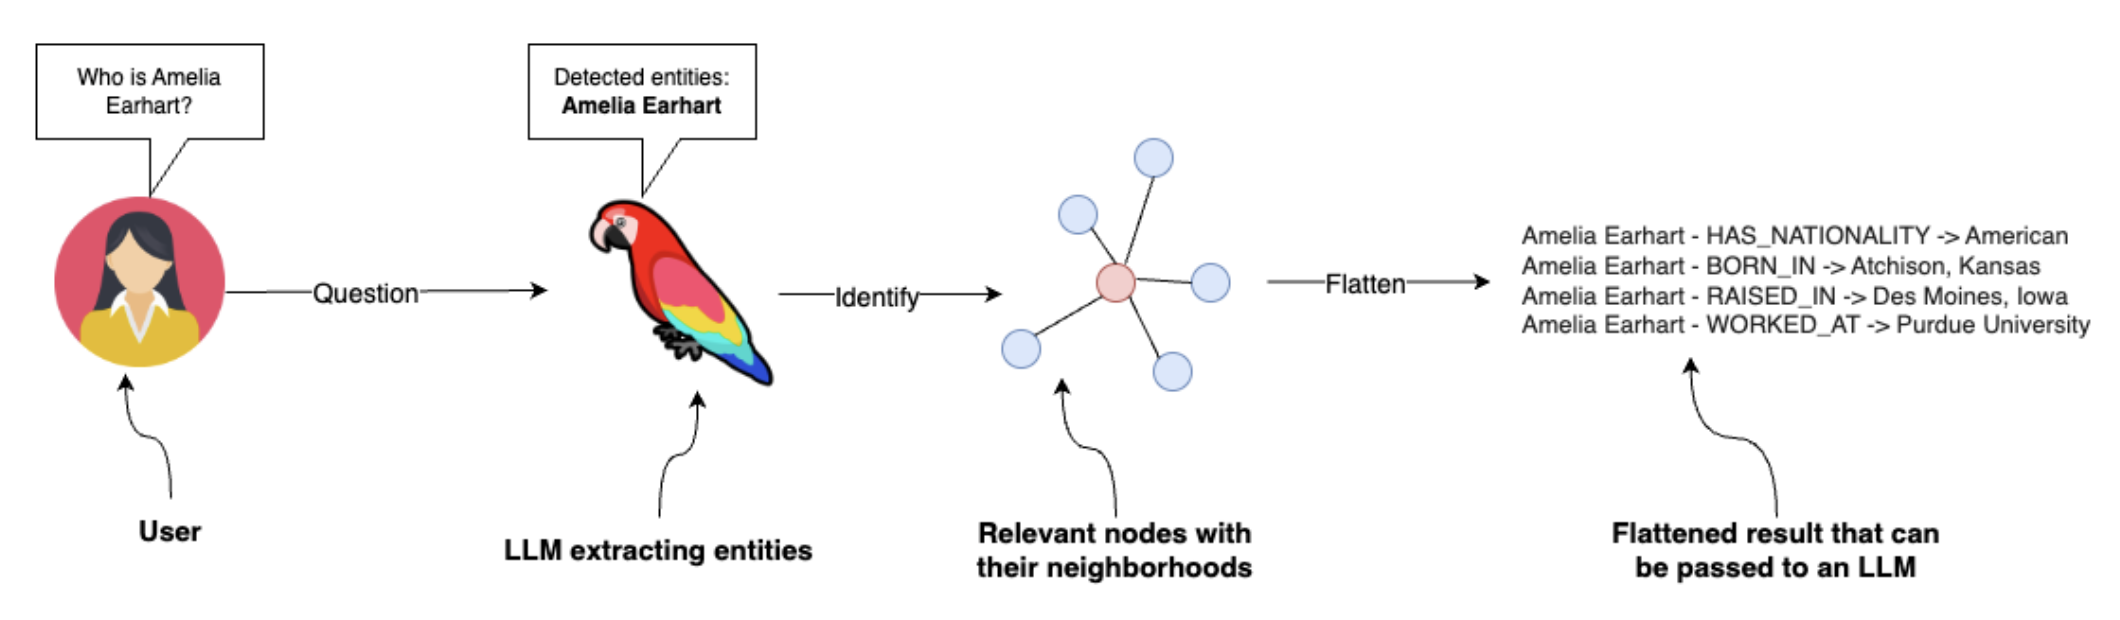
The graph retriever starts by identifying relevant entities in the input. For simplicity, we instruct the LLM to identify people, organizations, and locations. To achieve this, we will use LCEL with the newly added ```with_structured_output``` method to achieve this.

In [147]:
llm = ChatGroq(model="mixtral-8x7b-32768", temperature=0)
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x32fa0f7f0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x32fa259c0>, temperature=1e-08, groq_api_key=SecretStr('**********'))

In [148]:
# Retriever

graph.query(
    "CREATE FULLTEXT INDEX entity IF NOT EXISTS FOR (e:__Entity__) ON EACH [e.id]")

# Extract entities from text
class Entities(BaseModel):
    """Identifying information about entities."""

    names: List[str] = Field(
        ...,
        description="All the person, organization, or company, financial entities that "
        "appear in the text",
    )

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are extracting organization, person, company, financial entities from the text.",
        ),
        (
            "human",
            "Use the given format to extract information from the following "
            "input: {input}",
        ),
    ]
)

entity_chain = prompt | llm.with_structured_output(Entities)

In [149]:
# test out the entity name identification
entity_chain.invoke({"input": "Nvidia's major markets are Data Center, Gaming, Professional Visualization, and Automotive."}).names

['Data Center', 'Gaming', 'Professional Visualization', 'Automotive']

In [150]:
entity_chain.invoke({"input": "Nvidia's revenue and gross margin growth."}).names

['Nvidia', 'revenue', 'gross margin', 'growth']

 Now that we can detect entities in the question, let's use a full-text index to map them to the knowledge graph. First, we need to define a full-text index and a function that will generate full-text queries that allow a bit of misspelling.

In [151]:
def generate_full_text_query(input: str) -> str:
    """
    Generate a full text query for the given input string.

    This function constructs a query string suitable for a full-text search.
    It process the input string by splitting it into words and appending a 
    similarity threshold (~2 changed characters) to each word, then combines
    them using the AND operator. Useful for mapping entities from user questions
    to knowledge graph nodes, and allow for some misspelling in the query.
    """
    full_text_query = ""
    words = [el for el in remove_lucene_chars(input).split() if el]
    for word in words[:-1]:
        full_text_query += f"{word}~2 AND "
    full_text_query += f"{words[-1]}~2"

    return full_text_query.strip()

In [152]:
# test generate_full_text_query
generate_full_text_query("Nvidia's major markets are Data Center, Gaming, Professional Visualization, and Automotive.")

"Nvidia's~2 AND major~2 AND markets~2 AND are~2 AND Data~2 AND Center,~2 AND Gaming,~2 AND Professional~2 AND Visualization,~2 AND and~2 AND Automotive.~2"

In [157]:
# Full text index query
def structured_retriever(question: str) -> str:
    """
    Collects the neibourhood of entities mentioned in a question.
    """

    result = ""
    entities = entity_chain.invoke({"input": question})
    print(entities)
    for entity in entities.names:
        response = graph.query(
            """
            CALL db.index.fulltext.queryNodes('entity', $query, {limit:10}) 
            YIELD node, score
            CALL {
                WITH node
                MATCH (node)-[r:!MENTIONS]->(neighbor)
                RETURN node.id + ' - ' + type(r) + ' -> ' + neighbor.id AS output
                UNION ALL
                WITH node
                MATCH (node)<-[r:!MENTIONS]-(neighbor)
                RETURN neighbor.id + ' - ' + type(r) + ' -> ' + node.id AS output
            }
            RETURN output LIMIT 20
            """,
            {"query": generate_full_text_query(entity)},
        )
        # print(response)
        result += "\n".join(el['output'] for el in response)
    
    return result

The ```structured_retriever``` function starts by detecting entities in the user question. Next, it iterates over the detected entities and uses a Cypher template to retrieve the neighborhood of relevant nodes. Let's test it out!

In [159]:
print(structured_retriever("Nvidia's revenue and gross margin growth."))

names=['Nvidia', 'revenue', 'gross margin', 'growth']
Nvda - RELATED_TO -> Issuer Purchases
Nvidia Rtx - FEATURE -> Deep Learning Super Sampling
Nvidia Rtx - FEATURE -> Ray Tracing
Nvidia Gpus - ENHANCES -> Gpu Computing Platform
Nvidia Omniverse - USED_FOR -> Virtual World Simulation
Nvidia Corporation - CEO -> Jen-Hsun Huang
Nvidia Corporation - CEO -> Jen-Hsun Huang
Nvidia Corporation - ACQUIRED -> Mellanox
Nvidia Corporation - ACQUIRED -> Arm
Nvidia Corporation - ACQUIRED -> Mellanox
Nvidia Corporation - SUBSIDIARY -> Nvidia Holdings
Nvidia Corporation - SUBSIDIARY -> Nvidia Singapore Pte Ltd
Nvidia Corporation - SUBSIDIARY -> Subsidiaries
Nvidia Corporation - SUBSIDIARY -> Nvidia International, Inc.
Nvidia Corporation - SUBSIDIARY -> Mellanox Technologies, Ltd
Nvidia Corporation - SUBSIDIARY -> Nvidia International Holdings Inc.
Nvidia Corporation - HEADQUARTERED_IN -> Santa Clara, California
Nvidia Corporation - HEADQUARTERED_IN -> Santa Clara
Nvidia Corporation - OPERATES_IN -> 

### Final retriever
we'll combine the unstructured and graph retriever to create the final context that will be passed to an LLM.

In [160]:
def combined_retriever(question: str) -> str:
    print(f'Search query: {question}')
    structured_data = structured_retriever(question)
    # structured_data = ""
    print(structured_data)  ## 
    unstructured_data = [el.page_content for el in vector_index.similarity_search(question)]
    print(unstructured_data)  ## 
    final_data = f"""
    Structured data: 
    {structured_data}\n\n
    Unstructured data:
    {"#Document ".join(unstructured_data)}
    """

    return final_data   

In [161]:
# unstructured_data = [el.page_content for el in vector_index.similarity_search("paul")]
# unstructured_data

In [162]:
# combined_retriever("paul")

## Define the RAG Chain

In [163]:
# Condense a chat history and follow-up question into a standalone question
_template = """Given the following conversation and a follow up question, rephrase the follow up question
to be a standalone question, in its original language. 
Chat history:
{chat_history}
Follow up question:
{question}
Standalone question:
"""      # noqa: E501
CONDENSE_QUESTION_PROMPT = PromptTemplate.from_template(_template)

def _format_chat_history(chat_history: List[Tuple[str, str]]) -> List:
    buffer = []
    for human, ai in chat_history:
        buffer.append(HumanMessage(content=human))
        buffer.append(AIMessage(content=ai))
    return buffer

_search_query = RunnableBranch(
    # If input includes chat_history, we condense it with follow-up question
    (
        RunnableLambda(lambda x: bool(x.get("chat_history"))).with_config(
            run_name="HasChatHistoryCheck"
        ),  # condense follow up question and chat into a standalone question
        RunnablePassthrough.assign(
            chat_history=lambda x: _format_chat_history(x["chat_history"])
        )
        | CONDENSE_QUESTION_PROMPT
        | ChatGroq(temperature=0)
        # | ChatOpenAI(temperature=0)
        | StrOutputParser(),
    ),
    # Else, we have no chat history, so just pass thru the question
    RunnableLambda(lambda x: x["question"]),
)

Next, we introduce a prompt that leverages the context provided by the integrated hybrid retriever to produce the response, completing the implementation of the RAG chain.

In [164]:
template = """Answer the question based only on the following context:
{context}

Question: {question}
Use natural language and be concise.
Answer:"""

prompt = ChatPromptTemplate.from_template(template)

chain = (
    RunnableParallel(
        {
            "context": _search_query | combined_retriever,
            "question": RunnablePassthrough(),
        }
    )
    | prompt
    | llm
    # | ChatOpenAI(temperature=0)
    | StrOutputParser()
)

Finally, we can go ahead and test our hybrid RAG implementation.

In [165]:
chain.invoke({"question": "What's Nvidia's major markets"}, 
             # config={'callbacks': [ConsoleCallbackHandler()]}
)

Search query: What's Nvidia's major markets
names=['Nvidia']
Nvda - RELATED_TO -> Issuer Purchases
Nvidia Rtx - FEATURE -> Deep Learning Super Sampling
Nvidia Rtx - FEATURE -> Ray Tracing
Nvidia Gpus - ENHANCES -> Gpu Computing Platform
Nvidia Omniverse - USED_FOR -> Virtual World Simulation
Nvidia Corporation - CEO -> Jen-Hsun Huang
Nvidia Corporation - CEO -> Jen-Hsun Huang
Nvidia Corporation - ACQUIRED -> Mellanox
Nvidia Corporation - ACQUIRED -> Arm
Nvidia Corporation - ACQUIRED -> Mellanox
Nvidia Corporation - SUBSIDIARY -> Nvidia Holdings
Nvidia Corporation - SUBSIDIARY -> Nvidia Singapore Pte Ltd
Nvidia Corporation - SUBSIDIARY -> Subsidiaries
Nvidia Corporation - SUBSIDIARY -> Nvidia International, Inc.
Nvidia Corporation - SUBSIDIARY -> Mellanox Technologies, Ltd
Nvidia Corporation - SUBSIDIARY -> Nvidia International Holdings Inc.
Nvidia Corporation - HEADQUARTERED_IN -> Santa Clara, California
Nvidia Corporation - HEADQUARTERED_IN -> Santa Clara
Nvidia Corporation - OPERATES

"Nvidia's major markets include artificial intelligence (AI) and computer graphics. In AI, they provide a complete platform for both training and inferencing, including GPUs, CPUs, DPUs, and software. They also offer AI-training-as-a-service and a solution for building enterprise-ready Large Language Models. In computer graphics, Nvidia focuses on enhancing the user experience for consumer entertainment and professional visualization applications, and creating new virtual world and simulation capabilities. Their technologies are used in the gaming, design, and creative industries."

In [166]:
chain.invoke(
    {
        "question": "What's Nvidia's revenue growth by each major markets?",
        "chat_history": [("What's Nvidia's major markets", "Nvidia's major markets are Data Center, Gaming, Professional Visualization, and Automotive.")],
    }
)

Search query: What is the revenue growth for each of Nvidia's major markets: Data Center, Gaming, Professional Visualization, and Automotive?
names=['Nvidia', 'Data Center', 'Gaming', 'Professional Visualization', 'Automotive']
Nvda - RELATED_TO -> Issuer Purchases
Nvidia Rtx - FEATURE -> Deep Learning Super Sampling
Nvidia Rtx - FEATURE -> Ray Tracing
Nvidia Gpus - ENHANCES -> Gpu Computing Platform
Nvidia Omniverse - USED_FOR -> Virtual World Simulation
Nvidia Corporation - CEO -> Jen-Hsun Huang
Nvidia Corporation - CEO -> Jen-Hsun Huang
Nvidia Corporation - ACQUIRED -> Mellanox
Nvidia Corporation - ACQUIRED -> Arm
Nvidia Corporation - ACQUIRED -> Mellanox
Nvidia Corporation - SUBSIDIARY -> Nvidia Holdings
Nvidia Corporation - SUBSIDIARY -> Nvidia Singapore Pte Ltd
Nvidia Corporation - SUBSIDIARY -> Subsidiaries
Nvidia Corporation - SUBSIDIARY -> Nvidia International, Inc.
Nvidia Corporation - SUBSIDIARY -> Mellanox Technologies, Ltd
Nvidia Corporation - SUBSIDIARY -> Nvidia Internat

"Nvidia's revenue growth for fiscal year 2024 was up by 126% and it was distributed among its major markets as follows: Data Center revenue was up by 217%, Gaming revenue was up by 15%, Professional Visualization revenue was up by 1%, and Automotive revenue was up by 21%."

In [168]:
chain.invoke({"question":"Nvidia's key financial indicators in fiscal year 2024"})

Search query: Nvidia's key financial indicators in fiscal year 2024
names=['Nvidia', 'fiscal year 2024', 'financial indicators']
Nvda - RELATED_TO -> Issuer Purchases
Nvidia Rtx - FEATURE -> Deep Learning Super Sampling
Nvidia Rtx - FEATURE -> Ray Tracing
Nvidia Gpus - ENHANCES -> Gpu Computing Platform
Nvidia Omniverse - USED_FOR -> Virtual World Simulation
Nvidia Corporation - CEO -> Jen-Hsun Huang
Nvidia Corporation - CEO -> Jen-Hsun Huang
Nvidia Corporation - ACQUIRED -> Mellanox
Nvidia Corporation - ACQUIRED -> Arm
Nvidia Corporation - ACQUIRED -> Mellanox
Nvidia Corporation - SUBSIDIARY -> Nvidia Holdings
Nvidia Corporation - SUBSIDIARY -> Nvidia Singapore Pte Ltd
Nvidia Corporation - SUBSIDIARY -> Subsidiaries
Nvidia Corporation - SUBSIDIARY -> Nvidia International, Inc.
Nvidia Corporation - SUBSIDIARY -> Mellanox Technologies, Ltd
Nvidia Corporation - SUBSIDIARY -> Nvidia International Holdings Inc.
Nvidia Corporation - HEADQUARTERED_IN -> Santa Clara, California
Nvidia Corpora

"Based on the provided structured data, Nvidia's key financial indicators in fiscal year 2024 include:\n\n- Deferred Tax Valuation Allowance, Sales Return Allowance, and Allowance For Doubtful Accounts in the accounts.\n- The fiscal year includes January 28, 2024.\n- Senior Notes were issued and located in the U.S.\n- The fiscal year was benefited by Irs Audit Resolution with an amount of $540 Million.\n- The fiscal year has a gross margin and relates to capital investments.\n- It is preceded by fiscal year 2025.\n\nHowever, the structured data does not provide specific values for these financial indicators, so a complete answer cannot be given."

In [169]:
chain.invoke({"question":"What are major factors to Nvidia's Data Center financial performance and why"})


Search query: What are major factors to Nvidia's Data Center financial performance and why
names=['Nvidia', 'Data Center', 'financial performance', 'major factors']
Nvda - RELATED_TO -> Issuer Purchases
Nvidia Rtx - FEATURE -> Deep Learning Super Sampling
Nvidia Rtx - FEATURE -> Ray Tracing
Nvidia Gpus - ENHANCES -> Gpu Computing Platform
Nvidia Omniverse - USED_FOR -> Virtual World Simulation
Nvidia Corporation - CEO -> Jen-Hsun Huang
Nvidia Corporation - CEO -> Jen-Hsun Huang
Nvidia Corporation - ACQUIRED -> Mellanox
Nvidia Corporation - ACQUIRED -> Arm
Nvidia Corporation - ACQUIRED -> Mellanox
Nvidia Corporation - SUBSIDIARY -> Nvidia Holdings
Nvidia Corporation - SUBSIDIARY -> Nvidia Singapore Pte Ltd
Nvidia Corporation - SUBSIDIARY -> Subsidiaries
Nvidia Corporation - SUBSIDIARY -> Nvidia International, Inc.
Nvidia Corporation - SUBSIDIARY -> Mellanox Technologies, Ltd
Nvidia Corporation - SUBSIDIARY -> Nvidia International Holdings Inc.
Nvidia Corporation - HEADQUARTERED_IN -> Sa

"Nvidia's Data Center financial performance is significantly influenced by the sales of their GPUs and other components in the data center platform. The growth of the data center platform has been driven by the expansion to include DPUs (Data Processing Units) and CPUs (Central Processing Units) in fiscal years 2022 and 2024 respectively. The company's software offerings, such as the CUDA parallel programming model, CUDA-X collection of acceleration libraries, APIs, SDKs, and domain-specific application frameworks, also contribute to the performance.\n\nIn fiscal year 2024, Nvidia launched the NVIDIA DGX Cloud, an AI-training-as-a-service platform, which includes cloud-based infrastructure and software for AI, customizable pretrained AI models, and access to NVIDIA experts. This service, hosted in leading cloud service providers' data centers, also significantly contributes to the Data Center segment's revenue.\n\nThe company's focus on enhancing the computing, networking, and storage 

In [170]:
chain.invoke({"question":"How does China impact Nvidia's financial indicators in fiscal year 2024"})

Search query: How does China impact Nvidia's financial indicators in fiscal year 2024
names=['China', 'Nvidia', 'fiscal year 2024', 'financial indicators']
China - SUBJECT_TO -> Taxation
China - TRADED_WITH -> Middle East
China - LEASE -> Facilities
China - DATA_TRANSFER_RESTRICTION -> United States
China - TRANSFERS_DATA_TO -> United States
China - EXPORT_RESTRICTION -> Usg
China - INVESTIGATES -> Risks Related To Regulatory, Legal, Our Stock And Other Matters
China - HOSTS -> Manufacturing Operations
China - LOCATION_OF -> International Sales
China - PART_OF -> Hong Kong
China - PART_OF -> Macau
Cyberspace Administration Of China - LOCATED_IN -> China
Supply Chain - AFFECTS -> Customer Demand
Supply Chain - RELATED -> Semiconductor Industry
Global Supply Chain - PARTNERS_WITH -> Csps
Global Supply Chain - PARTNERS_WITH -> Data Center Co-Location Partners
Supply Chain Governance - MANAGES -> Business Operations
Supply Chain Delays - DISRUPTS -> Business Operations
Chief Executive Offi

"China's impact on Nvidia's financial indicators in fiscal year 2024 is a decrease in Nvidia's Data Center revenue as a percentage of total revenue, from 19% in fiscal year 2023 to 14% in fiscal year 2024. This is due to USG licensing requirements that impact exports to China of certain Nvidia products, which has led to a reduction in sales to China. Nvidia has started to ship alternatives to the China market in small volumes and expects China to represent a mid-single digit percentage of their Data Center revenue in the first quarter of fiscal year 2025. However, Nvidia's competitive position has been harmed, and there is potential for future disruption to product development or operations if the conflict continues."

In [358]:
# chain.invoke({"question":"what's the content"})
for chunk in chain.stream({"question":"what's the content"}):
    print(chunk, end="", flush=True)

Search query: what's the content
names=["what's the content"]

['\ntext: Elon Musk completed his acquisition of Twitter in October 2022; Musk acted as CEO of Twitter until June 2023 when he was succeeded by Linda Yaccarino. Twitter was then rebranded to X in July 2023. Initially during Musk\'s tenure, Twitter introduced a series of reforms and management changes; the company reinstated a number of previously banned accounts, reduced the workforce by approximately 80%, closed one of Twitter\'s three data centers, and largely eliminated the content moderation team, replacing it with the crowd-sourced fact-checking system Community Notes.\nIn November 2022, Twitter then began offering paid verification checkmarks, followed by removing legacy verification. In December, the Twitter Files were released and a number of journalists suspended from the platform. The following year, a variety of further changes were made; API access restrictions, developer agreements updated, transgender hate con

In [94]:
# sanity check
graph.query("""
match (n:Company)-[:EXPORT]->(m) 
where n.id contains "Gale Pacific"            
return m.id AS Destination
""")

[]

In [359]:
showGraph("""
match p1=(n:Company)-[:!MENTIONS]->() 
with p1, n
match p2=()-[:!MENTIONS]->(n:Company)
where n.id contains "Gale Pacific"            
return p1, p2
""")

GraphWidget(layout=Layout(height='500px', width='100%'))